# Data wrangling and exploration - Wikipedia citation records

* Read bulk TSV files, select and process informative columns. Construct a directed bipartite graph of web pages and cited publications, and analyze the graph properties.

### 1. Raw data collection

The primary source of data for Wikipedia citation statistics comes from online repository: https://analytics.wikimedia.org/datasets/archive/public-datasets/all/mwrefs/mwcites-20180301/
The datasets for different languages are stored in separate archives, each containing a 'tab-separated values' (TSV) files.

### 2. Data cleaning

The TSV files were read into a pandas dataframe. The datasets contain 6 features: page_id, page_title, rev_id, timestamp, type, and id. The data is already clean, the only modification was to convert wikipedia webpage named 'NaN' (describing the concept of not-a-number) to a string, rather than NaN value, as interpretted by pandas read_csv().


### 3. Construction of graph representation of the web pages and publications

Using networkx library, directed bipartite graph was constructed to represent the relations between pages and publications. The unique values of page ids ('page_id') and publication ids ('id') were converted to graph nodes, and pairs of 'page_id' and 'id' from the dataframe records were converted to edges. Each node has the 'bipartite' property.


### 4. Exploration of graph properties

Degree of centrality (DOC) was calcualted for both partitions, and most connected pages and publications were determined. The DOC distribution is most conveniently presented in a log-log plot. The near-linear dependence between the logs of publications and logs of their DOCs suggests a power relation between the two. Save graph in JSON format

### 5. Explore wikipedia in python

Try 'wikipedia' library to get infromation from pages

## Data wrangling code

In [1]:
import os
import numpy as np
import pandas as pd
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt

The Wikipedia data is in the form of series of language-specific TSV files, which were downloaded into a local directory (data/raw).

In [2]:
base_path = '../data/raw'
processed_path = '../data/processed'

In [3]:
# read TSV data
df = pd.read_csv(os.path.join(base_path,'enwiki.tsv'), sep='\t', parse_dates=['timestamp'],infer_datetime_format=True)

# Convert mistakenly converted type nan to string 'NaN' (wikipedia page name)
df.page_title = df.page_title.fillna("NaN")

df.head(5)

,page_id,page_title,rev_id,timestamp,type,id
0,2867096,Mu Aquilae,503137751,2012-07-19 16:08:41,doi,10.1051/0004-6361:20078357
1,2867096,Mu Aquilae,508363722,2012-08-20 22:56:21,arxiv,astro-ph/0604502
2,2867096,Mu Aquilae,508363722,2012-08-20 22:56:21,arxiv,astro-ph/0003329
3,2867096,Mu Aquilae,508363722,2012-08-20 22:56:21,arxiv,0708.1752
4,2867096,Mu Aquilae,503137751,2012-07-19 16:08:41,doi,10.1051/0004-6361:20064946


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3794695 entries, 0 to 3794694
Data columns (total 6 columns):
page_id       int64
page_title    object
rev_id        int64
timestamp     datetime64[ns]
type          object
id            object
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 173.7+ MB


**Create a bipartite graph**

Prepare lists of nodes and edges from the dataframe

In [5]:
# list of unique web pages (web_page nodes)
wpages = df.page_id.unique()

# list of unique publications (publication nodes)
pubs = df.id.unique()

# list of references (edges)
edges = [(page, pub) for page, pub in df[['page_id', 'id']].values]

In [6]:
len(wpages), len(pubs), len(edges)

(857765, 2190762, 3794695)

Create a bipartite directed graph 

In [7]:
G = nx.DiGraph()
G.add_nodes_from(wpages, bipartite='web_page')
G.add_nodes_from(pubs, bipartite='publication')
G.add_edges_from(edges)

Make lists of web_page and publication nodes (same as above but, now extracted directly from the graph)

In [8]:
wpage_nodes = [node for node, data in G.nodes(data=True) if data['bipartite']=='web_page']
pub_nodes = [node for node, data in G.nodes(data=True) if data['bipartite']=='publication']

Calculate bipartite degree centrality

In [9]:
dcent = nx.bipartite.degree_centrality(G, wpage_nodes)

Assign degree of centrality to the two partitions and rank nodeds within each partition

In [10]:
# webpage ranking
wpage_dcent = [(node, dcent[node]) for node in wpage_nodes]
wpage_rank = sorted(wpage_dcent, key=lambda x: x[1], reverse=True)

# publication ranking
pub_dcent = [(node, dcent[node]) for node in pub_nodes]
pub_rank = sorted(pub_dcent, key=lambda x: x[1], reverse=True)

**Look at the most prominent web pages and publications**

In [11]:
top_page = df.loc[df.page_id == wpage_rank[0][0]].iloc[0]['page_title']
print('Web page with most references:', top_page)
print('Number of references:', df.loc[df.page_id == wpage_rank[0][0]].shape[0])
df.loc[df.page_id == wpage_rank[0][0]].head()

Web page with most references: 2017 in paleontology
Number of references: 930


,page_id,page_title,rev_id,timestamp,type,id
2863256,52206193,2017 in paleontology,748990989,2016-11-11 17:21:59,doi,10.1017/S0016756816000236
2863257,52206193,2017 in paleontology,793738221,2017-08-03 16:49:35,doi,10.1016/j.cub.2017.06.071
2863258,52206193,2017 in paleontology,804164124,2017-10-07 05:05:59,pmid,28489871
2863259,52206193,2017 in paleontology,787972457,2017-06-28 18:08:23,doi,10.3140/bull.geosci.1668
2863260,52206193,2017 in paleontology,768238206,2017-03-02 16:51:02,doi,10.5710/AMGH.05.09.2016.3009


Most cited publication (english): "Encyclopedia Of All Footballers (10th Edition)"

In [13]:
print('Number of citations:', df.loc[df.id == pub_rank[0][0]].shape[0])
df.loc[df.id == pub_rank[0][0]].head()

Number of citations: 4769


,page_id,page_title,rev_id,timestamp,type,id
206501,3415451,List of VFL/AFL players with international bac...,798221651,2017-08-31 17:13:15,isbn,9781921496325
368444,5271083,Vic Cumberland,794792437,2017-08-10 02:26:43,isbn,9781921496325
704178,13802361,Ian Mort,714356193,2016-04-09 07:02:30,isbn,9781921496325
834821,15292398,Syd Barker Sr.,640627969,2015-01-02 08:53:41,isbn,9781921496325
1303211,19228797,Athol Milne,717048257,2016-04-25 12:26:15,isbn,9781921496325


(1, 4545951.0085820798)

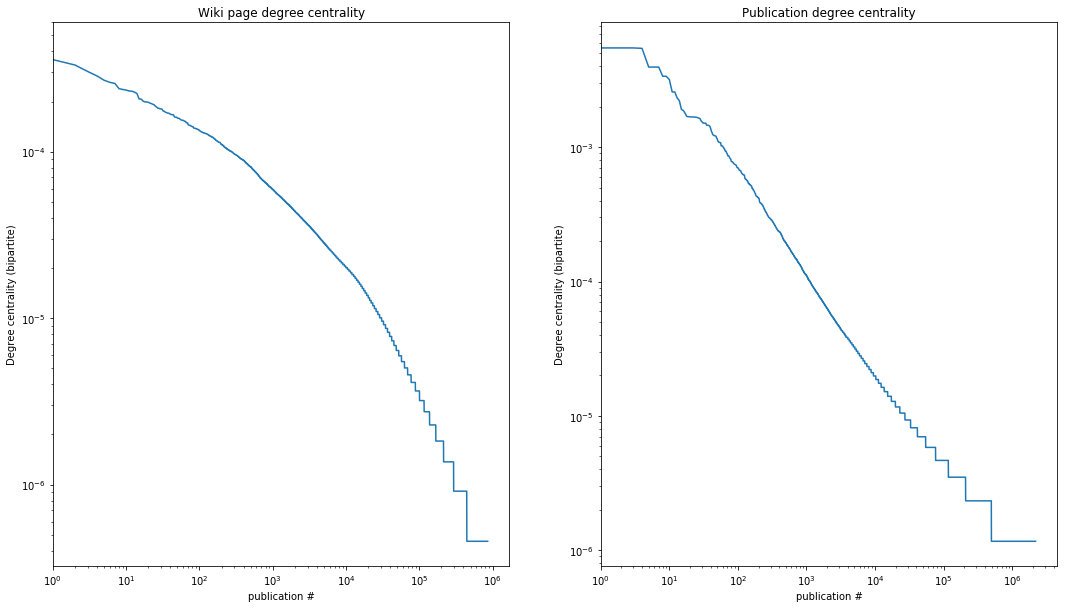

In [14]:
plt.figure(figsize=(18,10))

plt.subplot(121)
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array(wpage_rank)[:,1])
plt.xlabel('publication #')
plt.ylabel('Degree centrality (bipartite)')
plt.title('Wiki page degree centrality')
plt.xlim(1,)

plt.subplot(122)
plt.xscale('log')
plt.yscale('log')
plt.plot(np.array(pub_rank)[:,1])
plt.xlabel('publication #')
plt.ylabel('Degree centrality (bipartite)')
plt.title('Publication degree centrality')
plt.xlim(1,)

Visualize bipartite graph (crashing - too big?)

In [12]:
#matrix = nx.bipartite.biadjacency_matrix(G, row_order=np.array(wpage_rank)[:,0], column_order=np.array(pub_rank)[:,0])

Create subgraphs starting on web pages (articles, categories) to calculate bipartite degree centrality for publications within categories.

In [15]:
def create_subgraph(G, node):
    nodes = nx.single_source_shortest_path(G,node).keys()
    return G.subgraph(nodes)

Save graph as JSON

In [18]:
from networkx.readwrite import json_graph
import json

In [33]:
def int64_to_int(o):
    """
    Convert np.int64 to python int - otherwise json.dumps does not work
    """
    if isinstance(o, np.int64): return int(o)  
    raise TypeError

json_string = json.dumps(json_graph.node_link_data(G), default=int64_to_int)

In [34]:
with open(os.path.join(processed_path, 'graph.json'), 'w') as fo:
    json.dump(json_string, fo)

In [35]:
import wikipedia

In [38]:
test_page = wikipedia.page(top_page)

In [58]:
len(test_page.references)

877

In [59]:
print(test_page.pageid)

52206193


In [60]:
print(test_page.parent_id)

853568029


In [61]:
print(test_page.categories)

['2010s in paleontology', '2017 in paleontology', '2017 in science', 'CS1 maint: Uses authors parameter', 'Pages with DOIs inactive since 2017']


In [64]:
another_page = wikipedia.page('walnut')

In [68]:
print(another_page.__dir__())

['title', 'original_title', 'pageid', 'url', '_categories', '__module__', '__doc__', '__init__', '__repr__', '__eq__', '_WikipediaPage__load', '_WikipediaPage__continued_query', '_WikipediaPage__title_query_param', 'html', 'content', 'revision_id', 'parent_id', 'summary', 'images', 'coordinates', 'references', 'links', 'categories', 'sections', 'section', '__dict__', '__weakref__', '__hash__', '__str__', '__getattribute__', '__setattr__', '__delattr__', '__lt__', '__le__', '__ne__', '__gt__', '__ge__', '__new__', '__reduce_ex__', '__reduce__', '__subclasshook__', '__init_subclass__', '__format__', '__sizeof__', '__dir__', '__class__']


In [69]:
another_page.url

'https://en.wikipedia.org/wiki/Walnut'